# Task 2 – Data Loading and Augmentation

We take the data from task 1, using the CustomDataset class we can load the data into the model, using torch DataLoader.
The data augmentation consists of a random horizontal flip, a random rotation up to 20 degrees and an affine transformation to make the model more robust for random patient oerientation. The randomaffine transform makes the model more robust. A scalejitter transformation makes the model more robust to images taken at different scales. Gaussian blur and noise make the model more robust to imperfect data.

In [31]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# define the global variables
input_dim=(256,256) # set the input dimension of the images to 256x256
channel_dim=1 # 1 for greyscale, 3 for RGB

In [34]:
# define the custom dataset class to load the images
class CustomDataset(Dataset):
    def __init__(self, img_size, class_names, path=None, transformations=None, num_per_class: int = -1, channel_dim='rgb'):
        self.img_size = img_size
        self.path = path
        self.num_per_class = num_per_class
        self.class_names = class_names
        self.transforms = transformations
        self.channel_dim = channel_dim
        self.data = []
        self.labels = []

        if path:
            self.readImages()

        # Default transforms applied to the testing and validation data
        self.standard_transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor()
        ])

    def readImages(self):
        for id, class_name in self.class_names.items():
            print(f'Loading images from class: {id} : {class_name}')
            img_path = glob.glob(os.path.join(self.path, class_name, '*.jpg'))
            if self.num_per_class > 0:
                img_path = img_path[:self.num_per_class]
            self.labels.extend([id] * len(img_path))
            for filename in img_path:
                if self.channel_dim == 3:
                    img = Image.open(filename).convert('RGB') # color in RGB
                else:
                    img = Image.open(filename).convert('L') # greyscale
                self.data.append(img)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transforms:
            img = self.transforms(img)  # Apply the custom transforms, including augmentations
        else:
            img = self.standard_transforms(img)  # Apply standard transforms if no custom ones are provided

        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [35]:
# define paths to the training, testing and validation data folders
train_path = "data/training/"
test_path = "data/testing/"
validation_path = "data/validation/"

# get the class names (pneumonia and normal)
class_names = [name[len(train_path):] for name in glob.glob(f'{train_path}*')]
class_names = dict(zip(range(len(class_names)), class_names))
class_names

{0: 'pneumonia', 1: 'normal'}

In [36]:
# Define the data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),      # Randomly rotate the image by 15 degrees
    transforms.RandomResizedCrop(input_dim),  # Random crop followed by resizing
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),              # Convert the image to a tensor
])

# Create an instance of CustomDataset with augmentations
train_dataset = CustomDataset(
    # Set the input dimension of the images to 256x256
    img_size=input_dim,
    # Set the class names
    class_names=class_names,
    # Set the path to the training data
    path=train_path,
    # Apply the defined transformations
    transformations=train_transform,
    # set the channel of the image (rgb or greyscale)
    channel_dim=channel_dim
)

# initialize the dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True)

Loading images from class: 0 : pneumonia
Loading images from class: 1 : normal


In [37]:
# create a dataset for the validation data
validation_dataset = CustomDataset(
    # Set the input dimension of the images to 256x256
    img_size=input_dim,
    # Set the class names
    class_names=class_names,
    # Set the path to the validation data
    path=validation_path,
    # set the channel of the image (rgb or greyscale)
    channel_dim=channel_dim
)

# initialize the dataloader
validation_dataloader = DataLoader(validation_dataset, shuffle=True)

Loading images from class: 0 : pneumonia
Loading images from class: 1 : normal


In [38]:
# create a dataset for the testing data
test_dataset = CustomDataset(
    img_size=input_dim,
    class_names=class_names,
    path=test_path,
    channel_dim=channel_dim
)

# initialize the dataloader
test_dataloader = DataLoader(test_dataset, shuffle=True)

Loading images from class: 0 : pneumonia
Loading images from class: 1 : normal


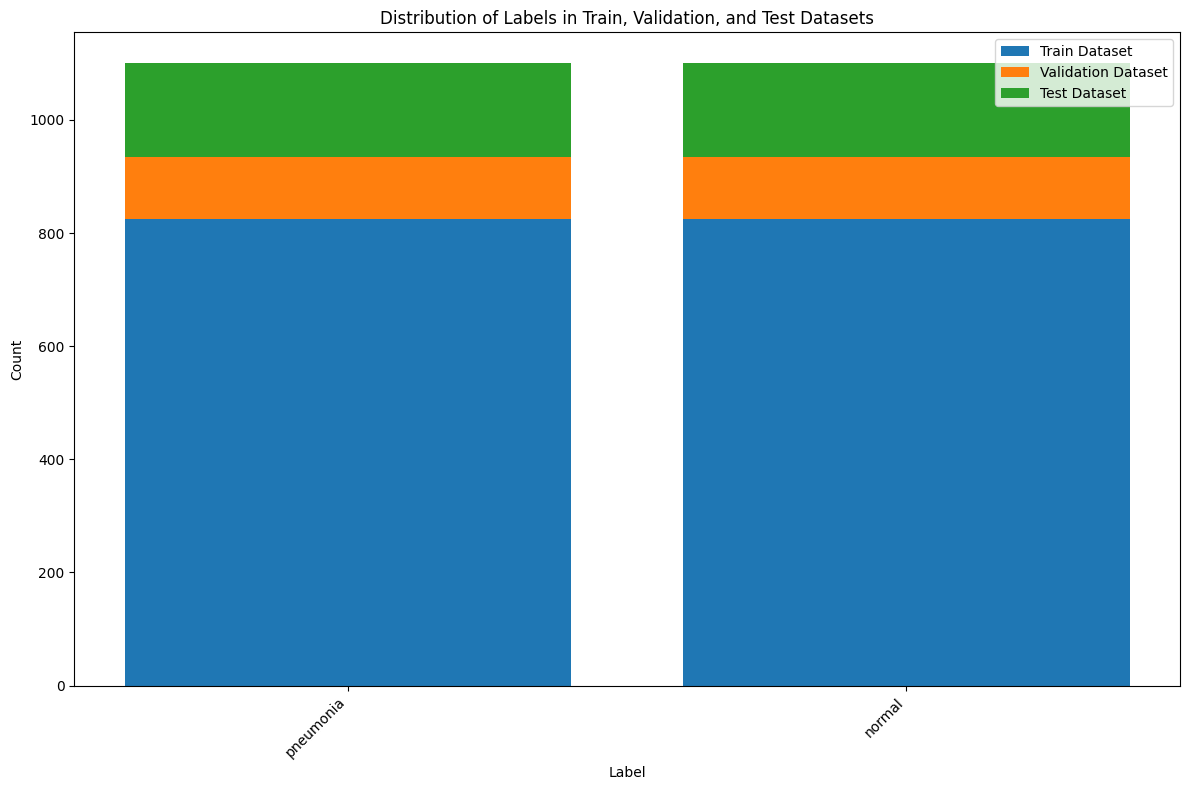

In [45]:
# collect the class distribution in the training, validation, and testing datasets
labels = [class_names[i] for i in class_names.keys()]
train_label_counts = [train_dataset.labels.count(i) for i in class_names.keys()]
validation_label_counts = [validation_dataset.labels.count(i) for i in class_names.keys()]
test_label_counts = [test_dataset.labels.count(i) for i in class_names.keys()]

# X locations for the groups
x = np.arange(len(labels))

# Plotting stacked bars
plt.figure(figsize=(12, 8))
plt.bar(x, train_label_counts, label='Train Dataset')
plt.bar(x, validation_label_counts, bottom=train_label_counts, label='Validation Dataset')
plt.bar(x, test_label_counts, bottom=np.array(train_label_counts) + np.array(validation_label_counts), label='Test Dataset')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Train, Validation, and Test Datasets')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

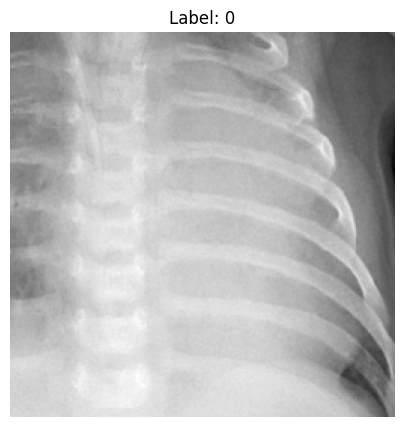

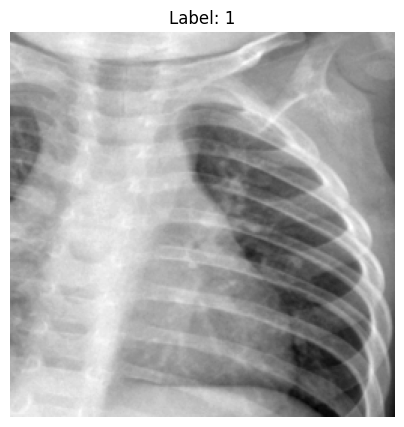

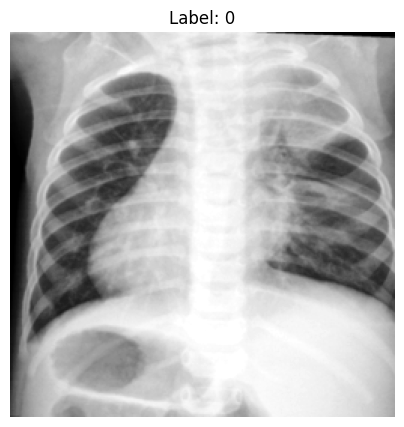

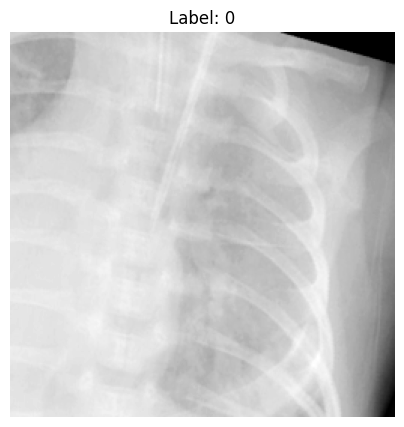

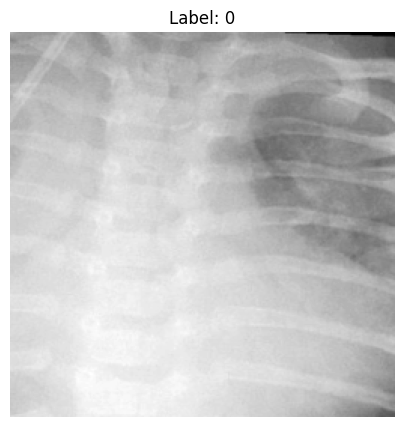

In [40]:
def visualize_images(images, labels):
    # Determine whether we're dealing with a single image or multiple images
    num_images = len(images)

    # if we have a single image, we need to convert it to a list for consistency
    if num_images == 1:
        fig, axs = plt.subplots(1, 1, figsize=(5, 5))
        axs.imshow(images[0].squeeze(), cmap='gray')
        axs.set_title(f"Label: {labels[0].item()}")
        axs.axis('off')
    else:
        fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
        if num_images == 1:
            axs = [axs]  # Convert to a list for consistency

        for i, (img, lbl) in enumerate(zip(images, labels)):
            axs[i].imshow(img.squeeze(), cmap='gray')
            axs[i].set_title(f"Label: {lbl.item()}")
            axs[i].axis('off')

    plt.show()
    
# Visualize first few images from the training dataloader
for i in range(5):
  images, labels = next(iter(train_dataloader))
  visualize_images(images, labels)